In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.layers import LSTM, Dense
from keras.models import Sequential
from matplotlib import pyplot as plt
from scipy import sparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tcn import TCN, tcn_full_summary

from model.data_parser import convert_jaad_dict_to_df, get_JAAD_data

In [2]:
#Load data
data_dir = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/data/JAAD_JSON_Labels/"

X, Y = convert_jaad_dict_to_df(get_JAAD_data(data_dir))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
sp_X_train = sparse.lil_matrix(X_train.values)
sp_Y_train = sparse.lil_matrix(Y_train.values)
sp_X_test = sparse.csr_matrix(X_test.values)
sp_Y_test = sparse.csr_matrix(Y_test.values)

Starting to read JAAD json files!


# Random forest

In [13]:
classifier = ClassifierChain(
        classifier=RandomForestClassifier(n_estimators=100),
        require_dense=[False, True]
    )

classifier.fit(sp_X_train, sp_Y_train)
# predict
predictions = classifier.predict(sp_X_test)

print(metrics.hamming_loss(sp_Y_test, predictions))
print(metrics.accuracy_score(sp_Y_test, predictions))

0.04928611760909898
0.8362507058159232


In [16]:
classifier.fit(X_train, Y_train)
predictions = classifier.predict(X_test)
df = pd.DataFrame.sparse.from_spmatrix(predictions)

0.04839880616278132
0.8384286520932483


TypeError: len() of unsized object

In [28]:
print(metrics.hamming_loss(Y_test, df))
print(metrics.accuracy_score(Y_test, df))
i=0
for col in df:
    df = df.rename(columns={col: str(int(col))})
for col in Y_test.columns:
    print(col + " accury:")
    print(metrics.accuracy_score(Y_test[col], df[str(i)]) )
    i += 1

0.04839880616278132
0.8384286520932483
look accury:
0.9244171977091232
action accury:
0.9409534564814068
cross accury:
0.8945712672420747
hand_gesture accury:
0.9983867064612406
nod accury:
0.9996773412922482


# BinaryRelevance

In [ ]:
clf = BinaryRelevance(
        classifier=SVC(),
        require_dense=[False, True]
    )

clf.fit(sp_X_train, sp_Y_train)
prediction = clf.predict(sp_X_test)


print(metrics.hamming_loss(sp_Y_test, prediction))
print(metrics.accuracy_score(sp_Y_test, prediction))

# LSTM

In [5]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings//cp_lstm_06.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [6]:
features, coordinate_values = X_train.shape
model = Sequential()
model.add(LSTM(64, input_shape=(coordinate_values, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid'))  # output layer，units is the unit number for output

# compile model
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,
                  metrics=[tf.keras.metrics.F1Score(
                      average='weighted', threshold=0.6, name='f1_score', dtype=None)])

model.fit(X_train, Y_train, epochs=11, batch_size=32, callbacks=[cp_callback])

# prediction
predictions = model.predict(X_test)

results = model.evaluate(X_test, Y_test, batch_size=128)
print(dict(zip(model.metrics_names, results)))

Epoch 1/11
1355/1356 [============================>.] - ETA: 0s - loss: 0.2432 - f1_score: 0.7377
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_06.ckpt
1356/1356 [==============================] - 25s 16ms/step - loss: 0.2432 - f1_score: 0.7377
Epoch 2/11
1356/1356 [==============================] - ETA: 0s - loss: 0.2264 - f1_score: 0.7423
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_06.ckpt
1356/1356 [==============================] - 22s 16ms/step - loss: 0.2264 - f1_score: 0.7423
Epoch 3/11
1356/1356 [==============================] - ETA: 0s - loss: 0.2236 - f1_score: 0.7432
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_06.ckpt
1356/1356 [==============================] - 22s 17ms/step - loss: 

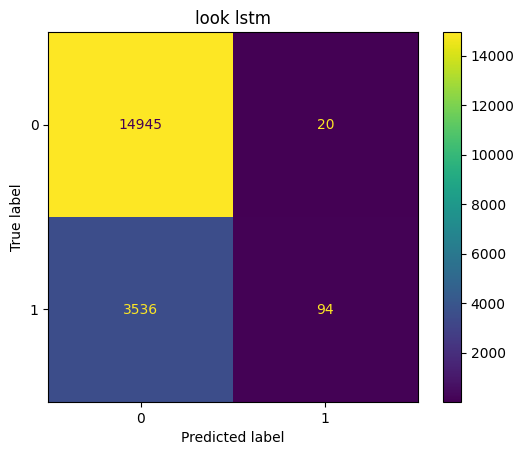

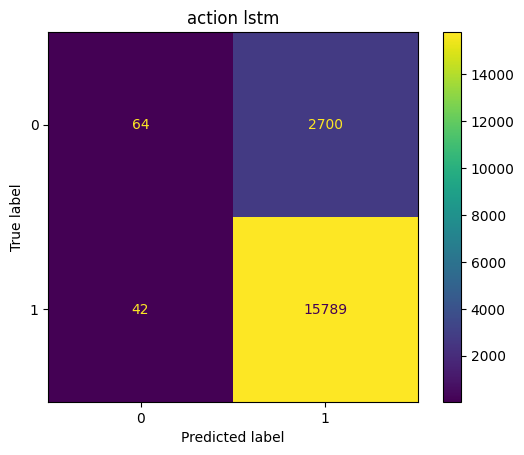

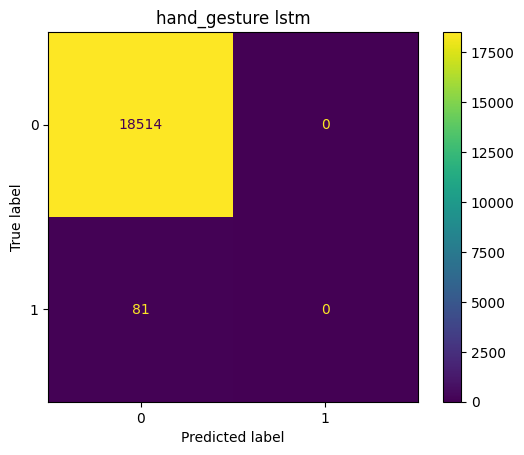

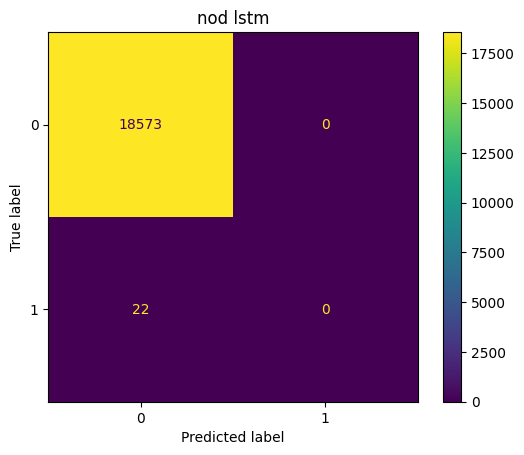

In [7]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.6 else 0 for x in (predictions[:, i])]
    cm = confusion_matrix((Y_test.to_numpy())[:, i], pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' lstm')
    plt.show()
    i += 1

In [3]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings//cp_lstm_05_{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [4]:
features, coordinate_values = X_train.shape
model = Sequential()
model.add(LSTM(64, input_shape=(coordinate_values, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid'))  # output layer，units is the unit number for output

# compile model
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,
                  metrics=[tf.keras.metrics.F1Score(
                      average='weighted', threshold=0.5, name='f1_score', dtype=None)])

model.save_weights(checkpoint_path.format(epoch=0))

model.fit(X_train, Y_train, epochs=11, batch_size=32, callbacks=[cp_callback])

# prediction
predictions = model.predict(X_test)

results = model.evaluate(X_test, Y_test, batch_size=128)
print(dict(zip(model.metrics_names, results)))

Epoch 1/11
1355/1356 [============================>.] - ETA: 0s - loss: 0.2402 - f1_score: 0.7418
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_05_0001.ckpt
1356/1356 [==============================] - 26s 18ms/step - loss: 0.2402 - f1_score: 0.7418
Epoch 2/11
1356/1356 [==============================] - ETA: 0s - loss: 0.2254 - f1_score: 0.7552
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_05_0002.ckpt
1356/1356 [==============================] - 24s 17ms/step - loss: 0.2254 - f1_score: 0.7552
Epoch 3/11
1356/1356 [==============================] - ETA: 0s - loss: 0.2225 - f1_score: 0.7603
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_05_0003.ckpt
1356/1356 [==============================] - 24s 18m

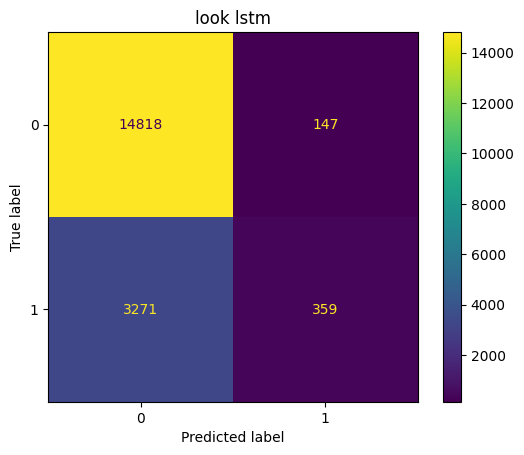

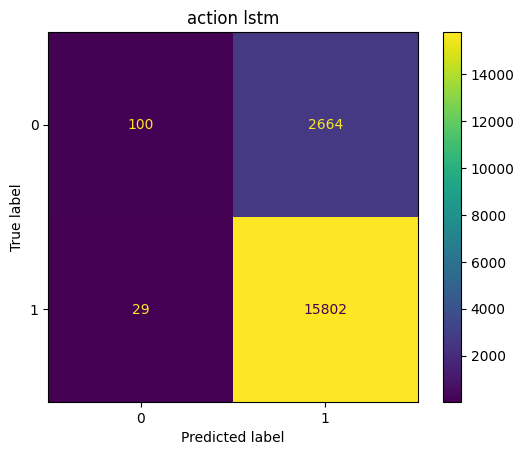

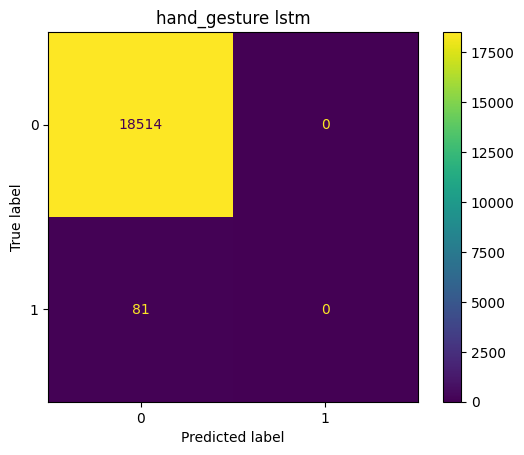

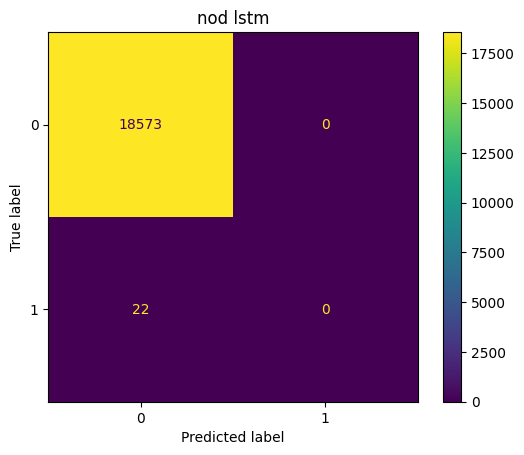

In [6]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.5 else 0 for x in (predictions[:, i])]
    cm = confusion_matrix((Y_test.to_numpy())[:, i], pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' lstm')
    plt.show()
    i += 1

# TCN

In [5]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings//cp_tcn_lstm_06.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [6]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.6, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

m.fit(X_train, Y_train, epochs=8, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/8
1000/1000 [==============================] - ETA: 0s - loss: 0.2179 - f1_score: 0.7520
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_06.ckpt
1000/1000 [==============================] - 81s 78ms/step - loss: 0.2179 - f1_score: 0.7520
Epoch 2/8
1000/1000 [==============================] - ETA: 0s - loss: 0.2032 - f1_score: 0.7654
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_06.ckpt
1000/1000 [==============================] - 80s 80ms/step - loss: 0.2032 - f1_score: 0.7654
Epoch 3/8
1000/1000 [==============================] - ETA: 0s - loss: 0.1964 - f1_score: 0.7736
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recogni

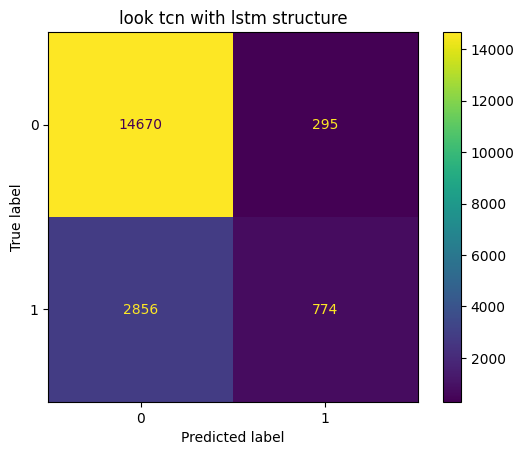

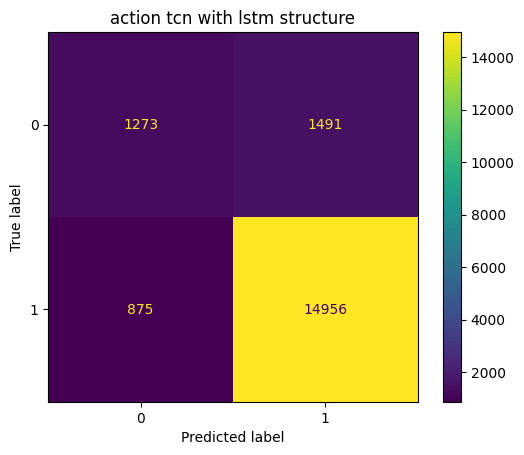

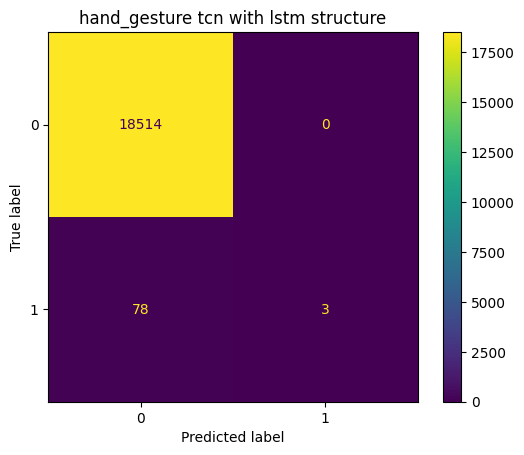

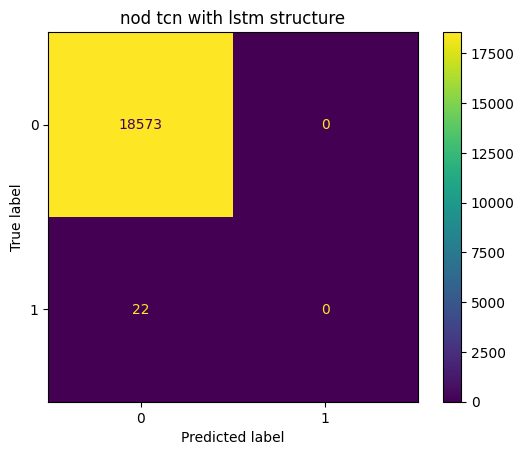

In [4]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.6 else 0 for x in (predictions[:, i])]
    cm = confusion_matrix((Y_test.to_numpy())[:, i], pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn with lstm structure')
    plt.show()
    i += 1

In [7]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings/cp_tcn_lstm_05.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [8]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.5, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

m.fit(X_train, Y_train, epochs=8, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/8
1000/1000 [==============================] - ETA: 0s - loss: 0.2182 - f1_score: 0.7656
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_05.ckpt
1000/1000 [==============================] - 88s 84ms/step - loss: 0.2182 - f1_score: 0.7656
Epoch 2/8
1000/1000 [==============================] - ETA: 0s - loss: 0.2041 - f1_score: 0.7788
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_05.ckpt
1000/1000 [==============================] - 85s 85ms/step - loss: 0.2041 - f1_score: 0.7788
Epoch 3/8
1000/1000 [==============================] - ETA: 0s - loss: 0.1966 - f1_score: 0.7867
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recogni

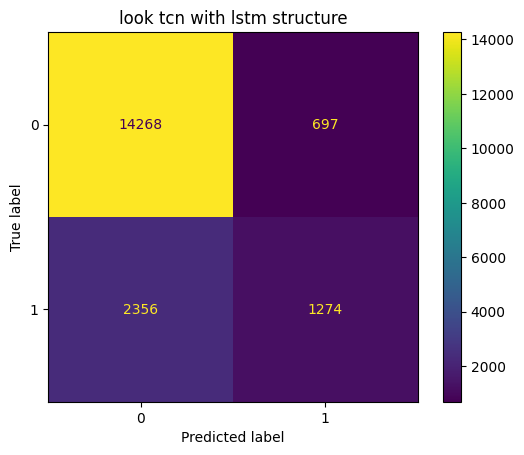

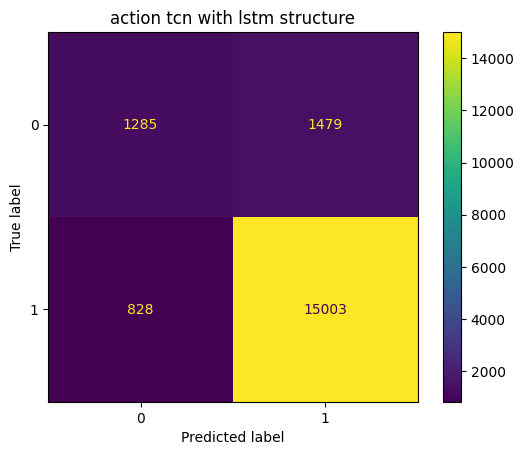

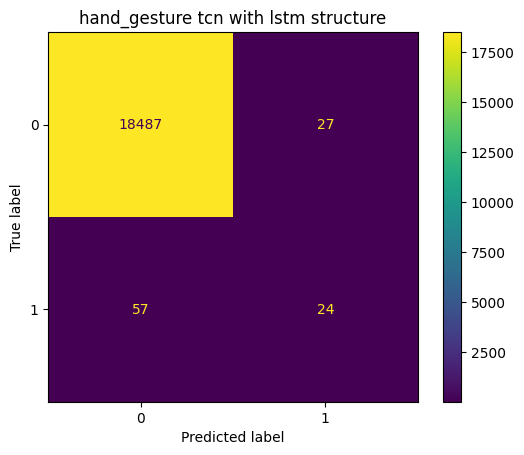

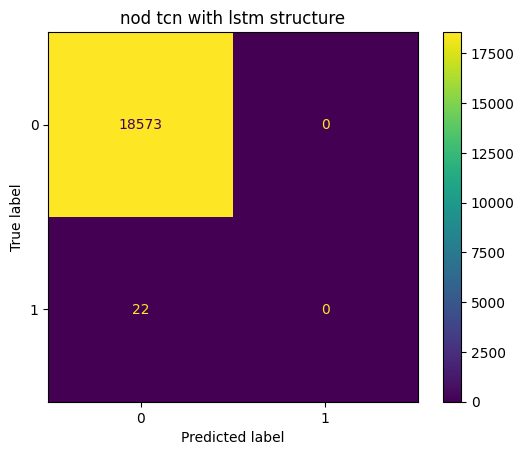

In [6]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.5 else 0 for x in (predictions[:, i])]
    cm = confusion_matrix((Y_test.to_numpy())[:, i], pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn with lstm structure')
    plt.show()
    i += 1

In [9]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings/cp_tcn_05.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [10]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.6, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

history = m.fit(X_train, Y_train,  epochs=10, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.2154 - f1_score: 0.7540
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_05.ckpt
1000/1000 [==============================] - 83s 80ms/step - loss: 0.2154 - f1_score: 0.7540
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.2010 - f1_score: 0.7650
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_05.ckpt
1000/1000 [==============================] - 81s 81ms/step - loss: 0.2010 - f1_score: 0.7650
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1943 - f1_score: 0.7726
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/sa

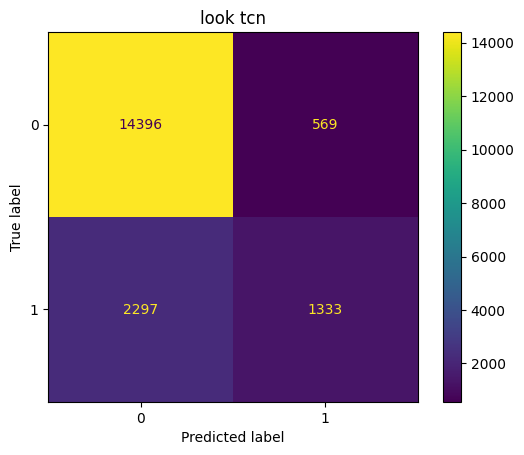

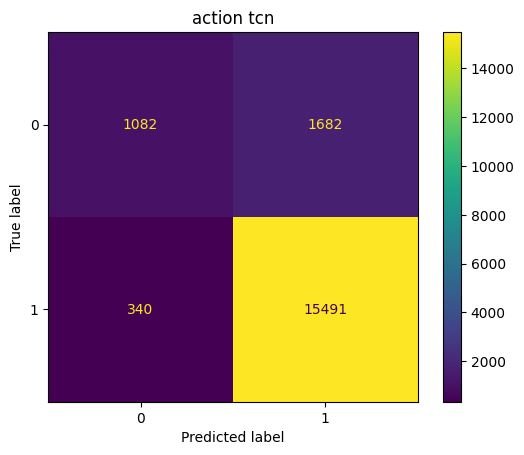

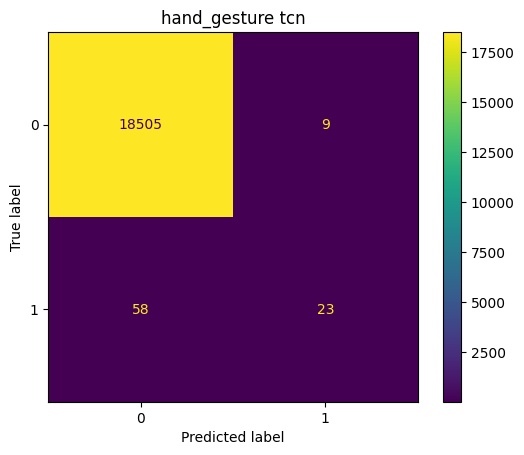

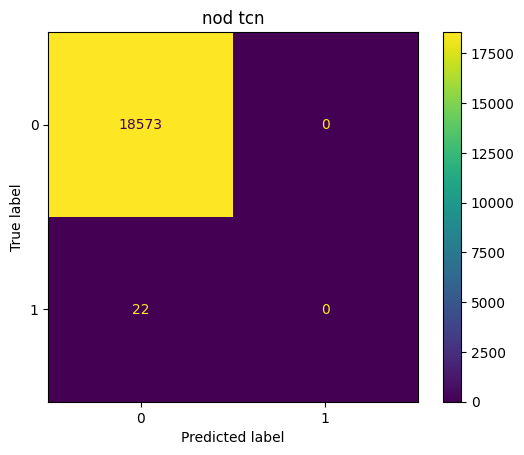

In [11]:
i = 0
for col in Y_train.columns:

    cm = confusion_matrix((Y_test.to_numpy())[:, i], np.round(predictions[:, i]))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn')
    plt.show()
    i += 1